In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [ ]:
def get_responses_steinmetz(alldat, k):
    #alldat is all the steinmetz data
    #k is the session number that you wish to extract
    dat=alldat[k]
    responses=dat['response']
    feedback= dat['feedback_type']
    contrast_diff = dat['contrast_right']-dat['contrast_left']
    keys_list = ["resp", "feedback","contrast diff"]
    values_list = [responses, feedback,contrast_diff]
    zip_iterator = zip(keys_list, values_list)
    global session_responses_dict
    session_responses_dict = dict(zip_iterator)

In [ ]:
correct = []
for session_n in range(0,39):
  get_responses_steinmetz(alldat, session_n)
  for n in np.arange(-1, 1.2, 0.25):
    feedback_idx = np.where(session_responses_dict['contrast diff'] == n)
    temp = session_responses_dict['feedback'][feedback_idx] == 1
    correct.append(temp.mean()*100)

total_mean_correct = np.mean(np.reshape(correct, (9, 39), order='F'), axis=1)
total_error = np.std(np.reshape(correct, (9, 39), order='F'), axis=1)

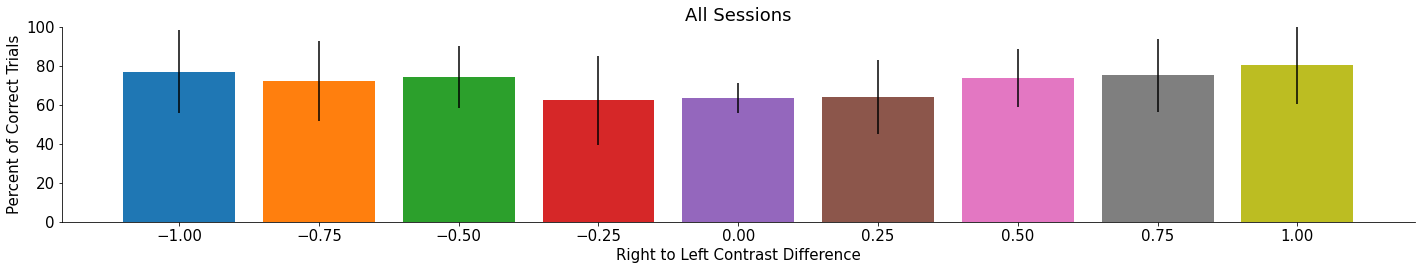

In [ ]:
LR_contrast = np.arange(-1, 1.2, 0.25)
for n in range(0, len(LR_contrast)):
  plt.bar(LR_contrast[n], total_mean_correct[n], width=0.2, label=LR_contrast[n], yerr = total_error[n])
plt.xticks(ticks=LR_contrast);
plt.xlabel('Right to Left Contrast Difference')
plt.ylabel('Percent of Correct Trials')
plt.title('Percent correct for all Sessions')
plt.ylim(0, 100);